<a href="https://colab.research.google.com/github/Rexoes/-dev-3/blob/main/PSO_FeatureSelection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [24]:
class Particle:
    def __init__(self, num_features):
        self.position = cp.random.randint(2, size=num_features)
        self.velocity = cp.random.uniform(-1, 1, num_features)
        self.pbest_position = self.position.copy()
        self.pbest_score = -1
        self.score = -1

    def update_velocity(self, gbest_position, w, c1, c2):
        r1, r2 = cp.random.rand(), cp.random.rand()
        cognitive = c1 * r1 * (self.pbest_position - self.position)
        social = c2 * r2 * (gbest_position - self.position)
        self.velocity = w * self.velocity + cognitive + social

    def update_position(self):
        sigmoid = 1 / (1 + cp.exp(-self.velocity))
        self.position = cp.where(cp.random.rand(len(sigmoid)) < sigmoid, 1, 0)

class PSOFeatureSelection:
    def __init__(self, X, y, num_particles=30, max_iter=20, w_max=0.9, w_min=0.4, c1_start=2.5, c2_start=0.5):
        self.X = cp.array(X)
        self.y = cp.array(y)
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.num_features = X.shape[1]
        self.gbest_position = None
        self.gbest_score = -1
        self.particles = [Particle(self.num_features) for _ in range(num_particles)]
        self.w_max = w_max
        self.w_min = w_min
        self.c1_start = c1_start
        self.c2_start = c2_start

    def fitness_function(self, position, X_train, y_train, X_test, y_test):
        selected_features = cp.where(position == 1)[0].get()

        if len(selected_features) == 0:
            return 0

        model = XGBClassifier(
            tree_method='gpu_hist',
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            early_stopping_rounds=10
        )

        X_train_np = cp.asnumpy(X_train[:, selected_features])
        X_test_np = cp.asnumpy(X_test[:, selected_features])
        y_train_np = cp.asnumpy(y_train)
        y_test_np = cp.asnumpy(y_test)

        model.fit(X_train_np, y_train_np, eval_set=[(X_test_np, y_test_np)], verbose=False)
        predictions = model.predict(X_test_np)

        return accuracy_score(y_test_np, predictions)

    def optimize(self):

        print(f"Parçacık Sayısı:{self.num_particles}, Max İterasyon:{self.max_iter}, NumOfFeatures:{self.num_features}")
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)

        for iter in range(self.max_iter):
            # Adaptif parametre ayarlamaları
            w = self.w_max - (self.w_max - self.w_min) * (iter / self.max_iter)
            c1 = self.c1_start - (self.c1_start - 0.5) * (iter / self.max_iter)
            c2 = self.c2_start + (2.5 - self.c2_start) * (iter / self.max_iter)

            for particle in self.particles:
                particle.score = self.fitness_function(particle.position, X_train, y_train, X_test, y_test)

                if particle.score > particle.pbest_score:
                    particle.pbest_position = particle.position.copy()
                    particle.pbest_score = particle.score

                if particle.score > self.gbest_score:
                    self.gbest_position = particle.position.copy()
                    self.gbest_score = particle.score

            for particle in self.particles:
                particle.update_velocity(self.gbest_position, w, c1, c2)
                particle.update_position()

            selected_features = cp.where(self.gbest_position == 1)[0].get()
            print(f"Iteration {iter + 1}/{self.max_iter} | w: {w:.3f}, c1: {c1:.3f}, c2: {c2:.3f}, gBest: {self.gbest_score:.4f}, Seçilen Özellikler: {selected_features}")

        # selected_features = cp.where(self.gbest_position == 1)[0].get()
        # print(f"\nPSO En İyi Doğruluk: {self.gbest_score:.4f}")
        # print(f"Seçilen Özellikler: {selected_features}")
        return selected_features

In [28]:
# 3. PCA ile Özellik Seçimi
def pca_feature_selection(X, n_components=10):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"\nPCA Açıklanan Varyans Oranı: {explained_variance:.4f}")
    return X_reduced

# 4. Model Değerlendirme
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, predictions))

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy

Hedef Değişken ile Özelliklerin Korelasyonu:
 Target        1.000000
Feature_16    0.200225
Feature_22    0.196671
Feature_7     0.195517
Feature_15    0.190542
Feature_29    0.175855
Feature_13    0.169495
Feature_25    0.158438
Feature_11    0.157202
Feature_18    0.126970
Feature_3     0.027180
Feature_4     0.023431
Feature_9     0.012844
Feature_28    0.009008
Feature_6     0.008429
Feature_5     0.000282
Feature_8    -0.002819
Feature_27   -0.005169
Feature_2    -0.006093
Feature_30   -0.008853
Feature_10   -0.009214
Feature_1    -0.014785
Feature_12   -0.057813
Feature_24   -0.071661
Feature_21   -0.082664
Feature_14   -0.144334
Feature_23   -0.166624
Feature_19   -0.195249
Feature_17   -0.212079
Feature_26   -0.212119
Feature_20   -0.216294
Name: Target, dtype: float64


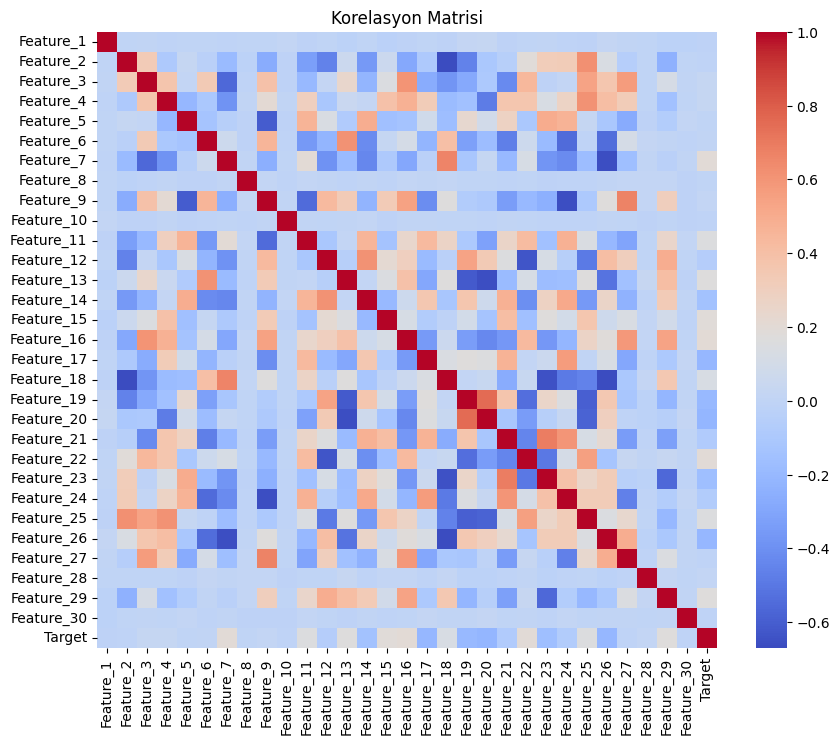

In [36]:
# 5. Ana Program

# Sentetik bir sınıflandırma veri seti oluşturma
X, y = make_classification(
    n_samples=6000,
    n_features=30,
    n_informative=10,
    n_redundant=15,
    n_classes=3,
    random_state=42
)

# Özellikleri ve hedef değişkeni bir DataFrame'e dönüştürme
df = pd.DataFrame(X, columns=[f"Feature_{i+1}" for i in range(X.shape[1])])
df['Target'] = y

# Korelasyon matrisini hesapla
corr_matrix = df.corr()

# Hedef değişkenle olan korelasyonu sıralama
target_corr = corr_matrix['Target'].sort_values(ascending=False)
print("Hedef Değişken ile Özelliklerin Korelasyonu:\n", target_corr)

# Korelasyon matrisini görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Korelasyon Matrisi")
plt.show()


Özellik Önem Skorları:
        Feature  Importance
26  Feature_27    0.109221
25  Feature_26    0.086264
8    Feature_9    0.079771
16  Feature_17    0.061313
5    Feature_6    0.042732
19  Feature_20    0.041130
10  Feature_11    0.039911
3    Feature_4    0.035091
6    Feature_7    0.034617
21  Feature_22    0.034594
14  Feature_15    0.033659
24  Feature_25    0.032913
28  Feature_29    0.032674
4    Feature_5    0.031358
15  Feature_16    0.030767
2    Feature_3    0.029172
12  Feature_13    0.029099
1    Feature_2    0.027865
13  Feature_14    0.027188
22  Feature_23    0.027148
17  Feature_18    0.023368
18  Feature_19    0.021790
11  Feature_12    0.019353
23  Feature_24    0.015784
20  Feature_21    0.014856
27  Feature_28    0.007816
0    Feature_1    0.007793
7    Feature_8    0.007694
9   Feature_10    0.007666
29  Feature_30    0.007393


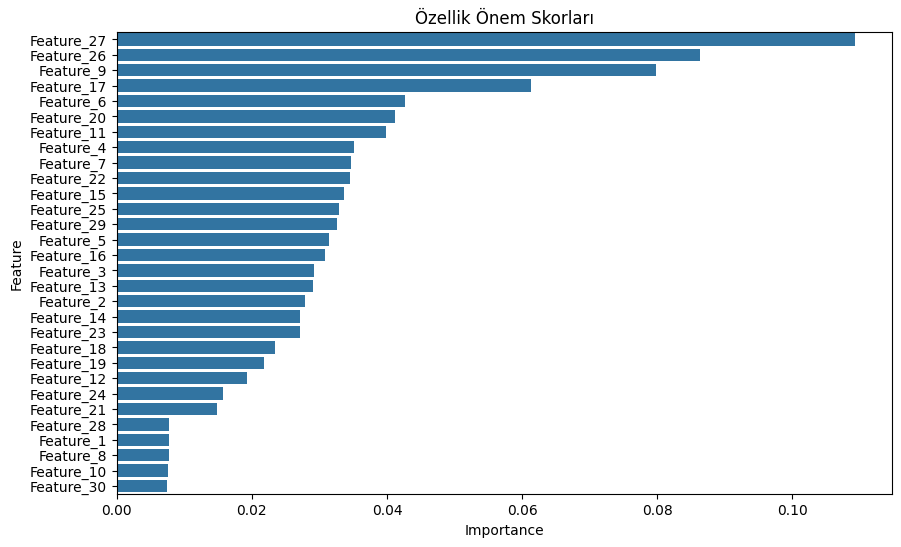

In [37]:
# Modeli eğit ve özellik önem skorlarını al
model = XGBClassifier()
model.fit(X, y)

# Özellik önem skorlarını elde et
importance = model.feature_importances_

# Özellikleri ve önem skorlarını birleştir
feature_importance = pd.DataFrame({
    'Feature': [f"Feature_{i+1}" for i in range(X.shape[1])],
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("\nÖzellik Önem Skorları:\n", feature_importance)

# Özellik önem skorlarını görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Özellik Önem Skorları")
plt.show()

In [38]:
# Tüm veri seti için ortak train/test ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# PSO ile özellik seçimi
pso_selector = PSOFeatureSelection(X, y, num_particles=80, max_iter=30)
selected_features_pso = pso_selector.optimize()

Parçacık Sayısı:80, Max İterasyon:30, NumOfFeatures:30
Iteration 1/30 | w: 0.900, c1: 2.500, c2: 0.500, gBest: 0.8839, Seçilen Özellikler: [ 0  1  2  3  4  5  6  8 10 12 13 14 15 18 20 21 24 25 26 28]
Iteration 2/30 | w: 0.883, c1: 2.433, c2: 0.567, gBest: 0.8878, Seçilen Özellikler: [ 0  2  4  5  6  9 12 13 14 16 18 20 21 22 25 26 27]
Iteration 3/30 | w: 0.867, c1: 2.367, c2: 0.633, gBest: 0.8883, Seçilen Özellikler: [ 1  5  8 11 12 14 15 16 18 19 20 21 22 25 26 28 29]
Iteration 4/30 | w: 0.850, c1: 2.300, c2: 0.700, gBest: 0.8928, Seçilen Özellikler: [ 1  2  3  4  5  6  7  8 10 11 12 14 15 16 19 20 21 23 25 26 28]
Iteration 5/30 | w: 0.833, c1: 2.233, c2: 0.767, gBest: 0.8928, Seçilen Özellikler: [ 1  2  3  4  5  6  7  8 10 11 12 14 15 16 19 20 21 23 25 26 28]
Iteration 6/30 | w: 0.817, c1: 2.167, c2: 0.833, gBest: 0.8939, Seçilen Özellikler: [ 0  1  4  5  6 11 12 13 14 15 16 17 18 19 20 21 22 25 26]
Iteration 7/30 | w: 0.800, c1: 2.100, c2: 0.900, gBest: 0.8956, Seçilen Özellikler: 

In [26]:
# PCA ile özellik seçimi
X_pca = pca_feature_selection(X, n_components=13)


PCA Açıklanan Varyans Oranı: 1.0000



PSO ile XGBoost Performansı:
XGBoost (PSO) Accuracy: 0.8983
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       608
           1       0.91      0.94      0.93       598
           2       0.89      0.90      0.89       594

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



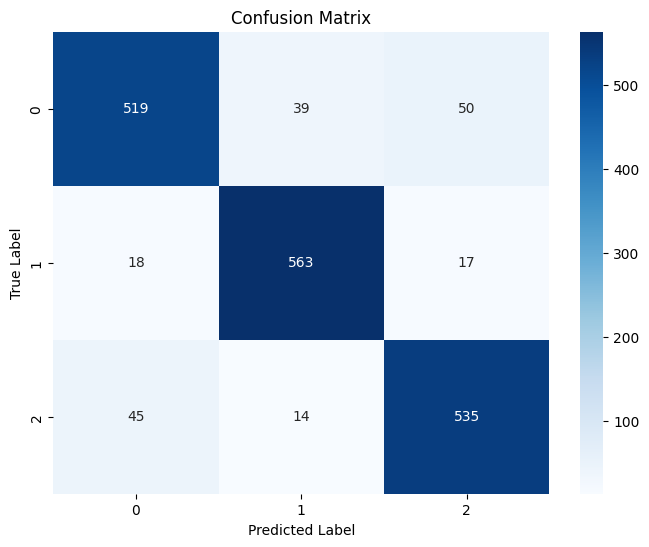

0.8983333333333333

In [39]:
# PSO ile seçilen özellikler kullanılarak train/test setlerini oluşturma
X_train_pso, X_test_pso = X_train[:, selected_features_pso], X_test[:, selected_features_pso]

# PCA ile azaltılmış özellikler kullanılarak train/test setlerini oluşturma
X_train_pca, X_test_pca = X_pca[:len(X_train)], X_pca[len(X_train):]

# XGBoost Model Performansı (PSO ve PCA ile)
print("\nPSO ile XGBoost Performansı:")
evaluate_model(
    XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, max_depth=5, learning_rate=0.1),
    X_train_pso, X_test_pso, y_train, y_test, "XGBoost (PSO)"
)


PSO ile XGBoost Performansı:
XGBoost (PSO All Features) Accuracy: 0.8994
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       608
           1       0.91      0.94      0.93       598
           2       0.89      0.89      0.89       594

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



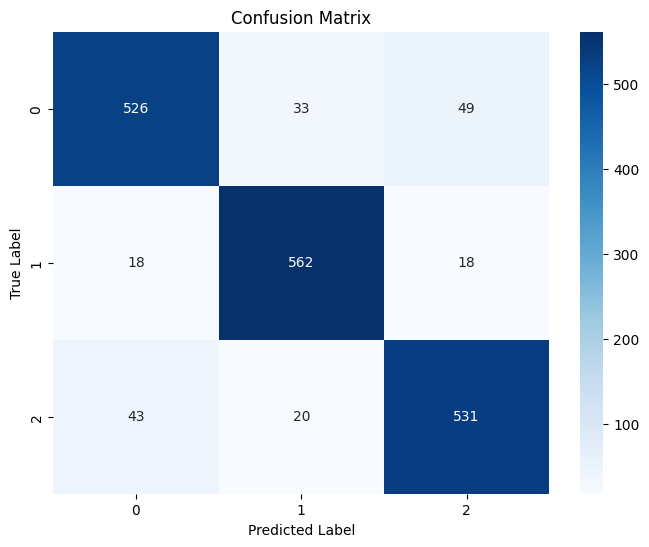

0.8994444444444445

In [40]:
# Tüm özellikler kullanılarak eğitim yap
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.3, random_state=42)

model_full = XGBClassifier(
    tree_method='gpu_hist',
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1
)

print("\nPSO ile XGBoost Performansı:")
evaluate_model(
    model_full, X_train_full, X_test_full, y_train_full, y_test_full, "XGBoost (PSO All Features)"
)

# model_full.fit(X_train_full, y_train_full)
# y_pred_full = model_full.predict(X_test_full)
# accuracy_full = accuracy_score(y_test_full, y_pred_full)
# print(f"Model Accuracy with All Features: {accuracy_full:.4f}")

In [17]:
print("\nPCA ile XGBoost Performansı:")
evaluate_model(
    XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, eval_metric='logloss'),
    X_train_pca, X_test_pca, y_train, y_test, "XGBoost (PCA)"
)


PCA ile XGBoost Performansı:
XGBoost (PCA) Accuracy: 0.3400
              precision    recall  f1-score   support

           0       0.35      0.33      0.34       610
           1       0.33      0.38      0.35       578
           2       0.34      0.32      0.33       612

    accuracy                           0.34      1800
   macro avg       0.34      0.34      0.34      1800
weighted avg       0.34      0.34      0.34      1800



0.34